In [1]:
#define preprocessing functions for all heuristics!

#preprocessing functions for 'regular Boyer-Moore' algorithm ( bad character and good sufix rules ) are mostly used from GI notebook : 
#https://github.com/vladimirkovacevic/gi-2020-etf/blob/master/notebooks/04_Boyer_Moore.ipynb

def z_array(s):
    assert len(s) > 1
    z = [len(s)] + [0] * (len(s)-1)
    # Initial comparison of s[1:] with prefix
    for i in range(1, len(s)):
        if s[i] == s[i-1]:
            z[1] += 1
        else:
            break
    r, l = 0, 0
    if z[1] > 0:
        r, l = z[1], 1
    for k in range(2, len(s)):
        assert z[k] == 0
        if k > r:
            # Case 1
            for i in range(k, len(s)):
                if s[i] == s[i-k]:
                    z[k] += 1
                else:
                    break
            r, l = k + z[k] - 1, k
        else:
            # Case 2
            # Calculate length of beta
            nbeta = r - k + 1
            zkp = z[k - l]
            if nbeta > zkp:
                # Case 2a: Zkp wins
                z[k] = zkp
            else:
                # Case 2b: Compare characters just past r
                nmatch = 0
                for i in range(r+1, len(s)):
                    if s[i] == s[i - k]:
                        nmatch += 1
                    else:
                        break
                l, r = k, r + nmatch
                z[k] = r - k + 1
    return z


def n_array(s):
    return z_array(s[::-1])[::-1]

def big_l_prime_array(p, n):
    lp = [0] * len(p)
    for j in range(len(p)-1):
        i = len(p) - n[j]
        if i < len(p):
            lp[i] = j + 1
    return lp


def big_l_array(p, lp):
    l = [0] * len(p)
    l[1] = lp[1]
    for i in range(2, len(p)):
        l[i] = max(l[i-1], lp[i])
    return l


def small_l_prime_array(n):
    small_lp = [0] * len(n)
    for i in range(len(n)):
        if n[i] == i+1:  # prefix matching a suffix
            small_lp[len(n)-i-1] = i+1
    for i in range(len(n)-2, -1, -1):  # "smear" them out to the left
        if small_lp[i] == 0:
            small_lp[i] = small_lp[i+1]
    return small_lp

def get_gc_table(pattern):
    n = n_array(pattern)
    lp = big_l_prime_array(pattern, n)
    return big_l_array(pattern, lp), small_l_prime_array(n)

def get_amap(alphabet) :
    alphabet_map = {}
    for i in range(len(alphabet)):
        alphabet_map[alphabet[i]] = i
    return alphabet_map

def get_bc_table(pattern, alphabet_map):
    bc_table = []
    nxt = [0] * len(alphabet_map)
    for i in range(0, len(pattern)):
        offset = alphabet_map[pattern[i]]
        bc_table.append(nxt[:])
        nxt[offset] = i+1
    return bc_table

#define Zhu-Takaoka heuristic table

def get_zht_matrix(pattern, alphabet_map):
    
    pattern_len = len(pattern)
    zht = [[pattern_len for i in range(len(alphabet_map))] for j in range(len(alphabet_map))]
    
    for i in range(len(alphabet_map)) :
        zht[i][alphabet_map[pattern[0]]] = pattern_len - 1
        
    for i in range(1, pattern_len - 1 ) :
        last = alphabet_map[pattern[i]]
        next_to_last = alphabet_map[pattern[i-1]]
        zht[next_to_last][last] = pattern_len - 1 - i
    
    return zht

#define functions for Smith algorithm - horsepool and quicksearch table!

def get_horsepool_table(pattern, alphabet_map):
    pattern_len = len(pattern)
    hp_table = [pattern_len for i in range(len(alphabet_map))]
    
    for i in range(0, pattern_len - 1 ) :
        hp_table[alphabet_map[pattern[i]]] = pattern_len - 1 - i
    
    return hp_table

def get_quicksearch_table(pattern, alphabet_map):
    pattern_len = len(pattern)
    qs = [pattern_len + 1 for i in range(len(alphabet_map))]
    
    for i in range(0, pattern_len ) :
        qs[alphabet_map[pattern[i]]] = pattern_len - i
        #print('i: ' + str(i)+ ' pattern[i] ' + str(pattern[i]) + ' amap: ' + str(alphabet_map[pattern[i]]) + ' pattern_len - i:  ' + str(pattern_len - i) )
    return qs


In [2]:
#Testing preprocessing functions
alphabet = 'ACGT'
pattern = 'GCAGAGAG'
correctAmap = {'A':0, 'C':1, 'G':2, 'T':3}
amap = get_amap(alphabet)
print('Alphabet map :' + str(amap))
assert amap == correctAmap

correctQsTable = [2,7,1,9]
quickSearchTable = get_quicksearch_table(pattern, amap)
print('Quicksearch table :' + str(quickSearchTable))
assert quickSearchTable == correctQsTable

correctHorsePoolTable = [1,6,2,8]
horsePoolTable = get_horsepool_table(pattern, amap)
print('Horsepool table :' + str(horsePoolTable))
assert horsePoolTable == correctHorsePoolTable

correctZhuTakTable = [[8,8,2,8],[5,8,7,8],[1,6,7,8],[8,8,7,8]]
zhuTakTable = get_zht_matrix(pattern, amap)
print('Zhu-Takaoka table :' + str(zhuTakTable))
assert zhuTakTable == correctZhuTakTable

Alphabet map :{'A': 0, 'C': 1, 'G': 2, 'T': 3}
Quicksearch table :[2, 7, 1, 9]
Horsepool table :[1, 6, 2, 8]
Zhu-Takaoka table :[[8, 8, 2, 8], [5, 8, 7, 8], [1, 6, 7, 8], [8, 8, 7, 8]]


In [9]:
#install pympler, which will be used for memory analysis
!pip install pympler
from pympler import asizeof

In [4]:
#Define BoyerMoore class which encapsulates all heuristics that we will implement
#in __init__ we will do all preprocessing, for all used heuristics
#used heuristics are defined with *args in __init__ 
#get_offset is function which returns maximum offset for specific cahracter comparison, based on used heuristics for specific BoyerMoore object

#define available heuristics
heuristic_bc = 'BC'
heuristic_gc = 'GC'
heuristic_zht = 'Zht'
heuristic_smith = 'Smith'
heuristic_names = [heuristic_bc, heuristic_gc, heuristic_zht, heuristic_smith]

#int to heuristic convertor (default heuristic is combination of bad character and good sufix)
def get_heuristics_by_args(args):
    if len(args) == 0 :
        h = dict(zip(heuristic_names, [False] * len(heuristic_names)))
        h[heuristic_bc] = True
        h[heuristic_gc] = True
        return h
    else :
        heuristics = [False] * len(heuristic_names)
        for arg in args:
            if not type(arg) is int:
                raise TypeError("Only integers are allowed ")
            if arg > len(heuristics) :
                raise TypeError("Unknown heuristic: ", arg)
            heuristics[arg - 1] = True
        return dict(zip(heuristic_names, heuristics))
            
#define object in charge of preprocessing and offset calculation    
class BoyerMoore(object):
    #heuristics are selected by args list of integers (integer represents index in heuristic_names list defined above )
    def __init__(self, pattern, alphabet, *args):
        self.pattern = pattern
        self.pattern_len = len(pattern)
        self.heuristics = get_heuristics_by_args(args)
        self.bc = self.gc = self.zht = self.smith = False
        #create helper structures that we need, based on choosed heuristics
        
        # alphabet postion array map
        if self.heuristics[heuristic_bc] or self.heuristics[heuristic_zht] or self.heuristics[heuristic_smith] :
            self.alphabet_map = get_amap(alphabet)
        
        if self.heuristics[heuristic_bc] :
            #print('Potrebna bc tabela')
            self.bc_table = get_bc_table(pattern, self.alphabet_map)
            self.bc = True
        
        if self.heuristics[heuristic_zht] :
            #print('Potrebna zht tabela')
            self.zht_table = get_zht_matrix(pattern, self.alphabet_map)
            self.zht = True
        
        if self.heuristics[heuristic_gc] or self.heuristics[heuristic_zht] :
            #print('Potrebne gc tabele')
            self.big_l, self.small_l_prime = get_gc_table(pattern)
            self.big_l_len = len(self.big_l)
            self.small_l_prime_len = len(self.small_l_prime)
            self.gc = True
        
        if self.heuristics[heuristic_smith] :
            self.hp = get_horsepool_table(pattern, self.alphabet_map)
            self.qs = get_quicksearch_table(pattern, self.alphabet_map)
            self.smith = True
    
    #returns memory used for preporocessing structures (only for selected heuristics)
    def get_memory_size(self):
        memory_size = 0
        if self.heuristics[heuristic_bc] or self.heuristics[heuristic_zht] or self.heuristics[heuristic_smith] :
            memory_size += asizeof.asizeof(self.alphabet_map)
            
        if self.heuristics[heuristic_bc] :
            memory_size += asizeof.asizeof(self.bc_table)
            
        if self.heuristics[heuristic_zht] :
            memory_size += asizeof.asizeof(self.zht_table)
            
        if self.heuristics[heuristic_gc] or self.heuristics[heuristic_zht] :
             memory_size += asizeof.asizeof(self.big_l) + asizeof.asizeof(self.small_l_prime)
                
        if self.heuristics[heuristic_smith] :
             memory_size += asizeof.asizeof(self.hp) + asizeof.asizeof(self.qs)
        
        return memory_size
             
    #all in one, function which encapsulates all implemented heuristics
    #diferent set of parameters is used for different heuristics
    def get_shift(self, matched, mismatch_index, mismatched_char, next_to_last_char, last_char, after_last_char):
        offset = 1 #minimum offset is 1
        temp = 0
        #bad character heuristic
        if self.bc :
            if matched :
                temp = 0
            else :
                temp = mismatch_index - (self.bc_table[mismatch_index][self.alphabet_map[mismatched_char]] - 1)
            offset = max(temp, offset)
        
        #zhu-takaoka heuristic
        if self.zht :
            if not matched : 
                #print('Pozvan zht ', matched, 'mis index: ', mismatch_index)
                last = self.alphabet_map[last_char]
                next_to_last = self.alphabet_map[next_to_last_char]
                temp = self.zht_table[next_to_last][last]
                offset = max(temp, offset)
        
        #good sufix rule is also used for zhu-takaoka heuristic 
        if self.gc or self.zht :
            if matched :
                temp = self.small_l_prime_len - self.small_l_prime[1]
            else:
                if mismatch_index == self.big_l_len - 1:
                    temp = 0
                else :
                    mismatch_index += 1  # i points to leftmost matching position of P
                    if self.big_l[mismatch_index] > 0 :
                        temp = self.big_l_len - self.big_l[mismatch_index]
                    else:
                        temp = self.big_l_len - self.small_l_prime[mismatch_index];
            
            offset = max(temp, offset)
        
        #smith heuristic combines horsepool and quick-search rules
        if self.smith :
            temp = max( self.hp[self.alphabet_map[last_char]], self.qs[self.alphabet_map[after_last_char]] )
            offset = max(temp, offset)
        return offset
    
    #define heuristic offset functions separately
    
    def get_gc_match(self):
        return max(1, self.small_l_prime_len - self.small_l_prime[1])
    
    def get_gc_mismatch(self, mismatch_index, mismatched_char):
        if mismatch_index == self.big_l_len - 1:
            return 0
        else :
            mismatch_index += 1  # points to leftmost matching position of P
            if self.big_l[mismatch_index] > 0 :
                return self.big_l_len - self.big_l[mismatch_index]
            else:
                return self.big_l_len - self.small_l_prime[mismatch_index];
    
    def get_bc_mismatch(self, mismatch_index, mismatched_char):
        return mismatch_index - (self.bc_table[mismatch_index][self.alphabet_map[mismatched_char]] - 1)
    
    def get_zh_mismatch(self, next_to_last_char, last_char):
        last = self.alphabet_map[last_char]
        next_to_last = self.alphabet_map[next_to_last_char]
        return self.zht_table[next_to_last][last]
    
    #no difference between match or mismatch for smith heuristic
    def get_smith(self, last_char, after_last_char):
        return max( self.hp[self.alphabet_map[last_char]], self.qs[self.alphabet_map[after_last_char]] )

In [5]:
#implementation of Boyer-Moore algorithm

def boyer_moore(bm_structure, text):
    i = 0
    occurrences = []
    args = []
    mismatch_index = 0
    mismatch_char = ''
    last_char = ''
    next_to_last_char = ''
    after_last_char = ''
    range_j = range(len(bm_structure.pattern)-1, -1, -1)
    last_index = len(text) - len(bm_structure.pattern)
    while i < len(text) - len(bm_structure.pattern) + 1:
        matched = True
        last_char = text[i+ bm_structure.pattern_len - 1]
        after_last_char = text[i + bm_structure.pattern_len] if i != last_index else ' '
        next_to_last_char = text[i+ bm_structure.pattern_len - 2]
        for j in range_j:
            if bm_structure.pattern[j] != text[i+j]:
                mismatch_index = j
                mismatch_char = text[i+j]
                matched = False
                break
        if matched:
            occurrences.append(i)
        shift = bm_structure.get_shift(matched, mismatch_index, mismatch_char, next_to_last_char, last_char, after_last_char)
        i += shift
    return occurrences

#implementation of naive algorithm, used as baseline algorithm in testing of Boyer-Moore algorithm
def naive_fast(text, pattern) : 
    i = 0
    occurrences = []
    range_j = range(len(pattern)-1, -1, -1)
    while i < len(text) - len(pattern) + 1:
        matched = True
        for j in range_j:
            if pattern[j] != text[i+j]:
                matched = False
                break
        if matched:
            occurrences.append(i)
        i += 1
    return occurrences

In [6]:
# heuristics are define above as: heuristic_names = [heuristic_bc, heuristic_gc, heuristic_zht, heuristic_smith]

pattern = 'ACAACA'
text = 'GACGGTTTTTTTTTTTTTTTTTGGCAGAGCGAGCGGCCCAACAACAACAACAACATTTTTTTTTTTTTTTTTCGCGCGACAGCGCACAACACTTTATTCATACAGC'

result1 = result2 = result3 = result4 = []

print('Bad character and good sufix >>>')
p_bm = BoyerMoore(pattern,'ACGT', 1, 2 )
result1 = boyer_moore(p_bm,text)
print('Preprocessing time : ')
%timeit BoyerMoore(pattern,'ACGT', 1, 2)
print('Searching time : ')
%timeit boyer_moore(p_bm,text)
print('Results: ' + str(result1))
print('Memory: ' + str(p_bm.get_memory_size())+ '\n\n')

print('Zhu Takaoka >>>')
p_bm = BoyerMoore(pattern,'ACGT', 3 )
result2 = boyer_moore(p_bm,text)
print('Preprocessing time : ')
%timeit BoyerMoore(pattern,'ACGT', 2)
print('Searching time : ')
%timeit boyer_moore(p_bm,text)
print('Results: ' + str(result2))
print('Memory: ' + str(p_bm.get_memory_size())+ '\n\n')

print('Smith >>>')
p_bm = BoyerMoore(pattern,'ACGT', 4 )
result3 = boyer_moore(p_bm,text)
print('Preprocessing time : ')
%timeit BoyerMoore(pattern,'ACGT', 4)
print('Searching time : ')
%timeit boyer_moore(p_bm,text)
print('Results: ' + str(result3))
print('Memory: ' + str(p_bm.get_memory_size())+ '\n\n')

print('Zhu Takaoka + Smith >>>')
p_bm = BoyerMoore(pattern,'ACGT', 3, 4 )
result4 = boyer_moore(p_bm,text)
print('Preprocessing time : ')
%timeit BoyerMoore(pattern,'ACGT', 3, 4)
print('Searching time : ')
%timeit boyer_moore(p_bm,text)
print('Results: ' + str(result4))
print('Memory: ' + str(p_bm.get_memory_size())+ '\n\n')

assert result1 == result2 == result3 == result4

#print(result1)
#print(p_bm.heuristics)

Bad character and good sufix >>>
Preprocessing time : 
29.8 µs ± 20.7 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Searching time : 
82.8 µs ± 60.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Results: [40, 43, 46, 49, 85]
Memory: 1880


Zhu Takaoka >>>
Preprocessing time : 
24.7 µs ± 24.1 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Searching time : 
73.4 µs ± 47.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Results: [40, 43, 46, 49, 85]
Memory: 1632


Smith >>>
Preprocessing time : 
13.7 µs ± 15 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Searching time : 
79 µs ± 83.1 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Results: [40, 43, 46, 49, 85]
Memory: 968


Zhu Takaoka + Smith >>>
Preprocessing time : 
41.8 µs ± 20.1 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Searching time : 
74.9 µs ± 57 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Results: [40, 43, 46, 49, 85]
Memory

In [10]:
"""One of project requirements is to compare time performances for different heuristics, but 
wrapped Boyer-Moore algorithm functions defined above aren't so good to do that. 
There is a lot of unnecessary comparions and arguments packing, so the results obtained in this way wouldn't be reliable.
To get more reliable time performance results we will define separate function for every heuristic that we want to test!
Functions may still not be the most optimal, but they give us more reliable results!
"""

#with bad character and good sufix
def boyer_moore_regular(bm_structure, text):
    i = 0
    occurrences = []
    range_j = range(len(bm_structure.pattern)-1, -1, -1)
    shift = 1
    while i < len(text) - len(bm_structure.pattern) + 1:
        matched = True
        for j in range_j:
            if bm_structure.pattern[j] != text[i+j]:
                matched = False
                shift = max(bm_structure.get_gc_mismatch(j, text[i+j]), bm_structure.get_bc_mismatch(j, text[i+j]))
                break
        if matched:
            occurrences.append(i)
            shift = bm_structure.get_gc_match()
        i += shift
    return occurrences

#with Zhu-Takaoka
def boyer_moore_zht(bm_structure, text):
    i = 0
    occurrences = []
    range_j = range(len(bm_structure.pattern)-1, -1, -1)
    shift = 1
    while i < len(text) - len(bm_structure.pattern) + 1:
        matched = True
        for j in range_j:
            if bm_structure.pattern[j] != text[i+j]:
                matched = False
                shift = max(bm_structure.get_gc_mismatch(j, text[i+j]), bm_structure.get_zh_mismatch(text[i+ bm_structure.pattern_len - 2], text[i+ bm_structure.pattern_len - 1]))
                break
        if matched:
            occurrences.append(i)
            shift = bm_structure.get_gc_match()
        i += shift
    return occurrences

#with Smith heuristic
def boyer_moore_smith(bm_structure, text):
    i = 0
    occurrences = []
    range_j = range(len(bm_structure.pattern)-1, -1, -1)
    last_char = ''
    after_last_char = ''
    last_index = len(text) - len(bm_structure.pattern)
    while i < len(text) - len(bm_structure.pattern) + 1:
        matched = True
        last_char = text[i+ bm_structure.pattern_len - 1]
        after_last_char = text[i + bm_structure.pattern_len] if i != last_index else ' '
        for j in range_j:
            if bm_structure.pattern[j] != text[i+j]:
                matched = False
                break
        if matched:
            occurrences.append(i)
        shift = bm_structure.get_smith(last_char,after_last_char)
        i += shift
    return occurrences

#combination of Zhu-Takaoka and Smith
def boyer_moore_smith_zht(bm_structure, text):
    i = 0
    occurrences = []
    range_j = range(len(bm_structure.pattern)-1, -1, -1)
    last_char = ''
    after_last_char = ''
    last_index = len(text) - len(bm_structure.pattern)
    while i < len(text) - len(bm_structure.pattern) + 1:
        matched = True
        last_char = text[i+ bm_structure.pattern_len - 1]
        after_last_char = text[i + bm_structure.pattern_len] if i != last_index else ' '
        for j in range_j:
            if bm_structure.pattern[j] != text[i+j]:
                matched = False
                shift = max(bm_structure.get_gc_mismatch(j, text[i+j]), bm_structure.get_zh_mismatch(text[i+ bm_structure.pattern_len - 2], last_char),bm_structure.get_smith(last_char,after_last_char))
                break
        if matched:
            occurrences.append(i)
            shift = max(bm_structure.get_gc_match(),bm_structure.get_smith(last_char,after_last_char))
        i += shift
    return occurrences

In [8]:
"""Do same tests that we did above with wrapped Boyer-Moore functions, now with specific BM functions"""

# heuristics are define above as: heuristic_names = [heuristic_bc, heuristic_gc, heuristic_zht, heuristic_smith]

pattern = 'ACAACA'
text = 'GACGGTTTTTTTTTTTTTTTTTGGCAGAGCGAGCGGCCCAACAACAACAACAACATTTTTTTTTTTTTTTTTCGCGCGACAGCGCACAACACTTTATTCATACAGC'

result1 = result2 = result3 = result4 = []

print('Bad character and good sufix >>>')
p_bm = BoyerMoore(pattern,'ACGT', 1, 2 )
result1 = boyer_moore_regular(p_bm,text)
print('Preprocessing time : ')
%timeit BoyerMoore(pattern,'ACGT', 1, 2)
print('Searching time : ')
%timeit boyer_moore_regular(p_bm,text)
print('Results: ' + str(result1))
print('Memory: ' + str(p_bm.get_memory_size())+ '\n\n')

print('Zhu Takaoka >>>')
p_bm = BoyerMoore(pattern,'ACGT', 3 )
result2 = boyer_moore_zht(p_bm,text)
print('Preprocessing time : ')
%timeit BoyerMoore(pattern,'ACGT', 2)
print('Searching time : ')
%timeit boyer_moore_zht(p_bm,text)
print('Results: ' + str(result2))
print('Memory: ' + str(p_bm.get_memory_size())+ '\n\n')

print('Smith >>>')
p_bm = BoyerMoore(pattern,'ACGT', 4 )
result3 = boyer_moore_smith(p_bm,text)
print('Preprocessing time : ')
%timeit BoyerMoore(pattern,'ACGT', 4)
print('Searching time : ')
%timeit boyer_moore_smith(p_bm,text)
print('Results: ' + str(result3))
print('Memory: ' + str(p_bm.get_memory_size())+ '\n\n')

print('Zhu Takaoka + Smith >>>')
p_bm = BoyerMoore(pattern,'ACGT', 3, 4 )
result4 = boyer_moore_smith_zht(p_bm,text)
print('Preprocessing time : ')
%timeit BoyerMoore(pattern,'ACGT', 3, 4)
print('Searching time : ')
%timeit boyer_moore_smith_zht(p_bm,text)
print('Results: ' + str(result4))
print('Memory: ' + str(p_bm.get_memory_size())+ '\n\n')

assert result1 == result2 == result3 == result4


Bad character and good sufix >>>
Preprocessing time : 
30.8 µs ± 14.7 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Searching time : 
58.5 µs ± 198 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Results: [40, 43, 46, 49, 85]
Memory: 1880


Zhu Takaoka >>>
Preprocessing time : 
24.9 µs ± 43.1 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Searching time : 
57.6 µs ± 56.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Results: [40, 43, 46, 49, 85]
Memory: 1632


Smith >>>
Preprocessing time : 
13.8 µs ± 13.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Searching time : 
58 µs ± 63.7 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Results: [40, 43, 46, 49, 85]
Memory: 968


Zhu Takaoka + Smith >>>
Preprocessing time : 
41.8 µs ± 79.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Searching time : 
67.4 µs ± 126 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Results: [40, 43, 46, 49, 85]
Memo

In [11]:
#import all that we need for testing on fasta files and results representation

from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt 
from Bio.SeqIO.FastaIO import FastaIterator

def fasta_iter(file):
    with open(file) as handle:
        for record in FastaIterator(handle):
            yield(record)
            


In [12]:
#Define test set

alphabet = 'ACGTN '
test1_patterns = ['ATGCATG','TCTCTCTA', 'TTCACTACTCTCA']
heuristics_to_test = [[1,2],[3],[4], [3,4]  ] 
heuristics_to_print = ['BM', 'Zhu-Takaoka', 'Smith', 'Zht-Smith' ]

test1 = {'file' : '/sbgenomics/project-files/13443_ref_Cara_1.0_chr1c.fa', 'patterns' : test1_patterns, 'heuristics' : heuristics_to_test, 'heur_print' : heuristics_to_print, 'name_print' : 'Cofee arabica Chromosome 1' }

test2_patterns = ['ATGATG','CTCTCTA', 'TCACTACTCTCA']
test2 = {'file' : '/sbgenomics/project-files/10093_ref_PAHARI_EIJ_v1.1_chrX.fa', 'patterns' : test2_patterns, 'heuristics' : heuristics_to_test, 'heur_print' : heuristics_to_print, 'name_print' : 'Mus Pahari Chromosome X'}

test3_patterns = ['TTTGTTTTCAGCTGAAGGATATACTTAAGGTGATGCTTTTGGCCTTTTCAGGGAGGGAGTCAGGGTTCCA','CTGAAGTGTTCCATGTGTTACTTTAGCTTGGT', 'AATAGAA']
test3 = {'file' : '/sbgenomics/project-files/vpa_ref_VicPac3.1_chr2.fa', 'patterns' : test3_patterns, 'heuristics' : heuristics_to_test, 'heur_print' : heuristics_to_print, 'name_print' : 'Vicugna pacos Chromosome 2'}

tests = [test1,test2,test3]

In [13]:
#Testing with specific BM functions

results = []
for test in tests : 
    print('Testing file: ' + test['name_print'])
    for it in fasta_iter(test['file']) :
        text = it.seq
        #text = 'AAAAAATTTTTTTTTCTCTCTATTTTTTTTTTTTTTTTTCCCCCTTCTTTCTTATATTTCTCTCTACGCTATGCATCGCAGTCGTCAGTCAGTCGTCGTCGTAGTCGTCAGTCAGTCAGTCTCTCTATCAGTCGTAGTCAGTCAGTCGTCAGTCAGT'
        text_len = len(text)
        
        test['times'] = []
        test['memory'] = []
        for pattern in test['patterns'] :
            print('\tPattern: ' + pattern)
            
            times = []
            memory = []
            
            print('\t\tBad character + good sufix: ')
            before = datetime.now()
            bm_object = BoyerMoore(pattern,alphabet, 1,2 )
            result = boyer_moore_regular(bm_object,text)
            search_time = datetime.now() - before 
            print('\t\t\tSearch time: ' + str(search_time.seconds) )
            times.append(search_time.seconds)
            memory.append(bm_object.get_memory_size())
            print('\t\t\tMemory: ' + str(bm_object.get_memory_size()) )
            
            print('\t\tZhu-Takaoka: ')
            before = datetime.now()
            bm_object = BoyerMoore(pattern,alphabet, 3 )
            result = boyer_moore_zht(bm_object,text)
            search_time = datetime.now() - before 
            print('\t\t\tSearch time: ' + str(search_time.seconds))
            times.append(search_time.seconds)
            memory.append(bm_object.get_memory_size())
            print('\t\t\tMemory: ' + str(bm_object.get_memory_size()) )
            
            print('\t\tSmith: ')
            before = datetime.now()
            bm_object = BoyerMoore(pattern,alphabet, 4 )
            result = boyer_moore_smith(bm_object,text)
            search_time = datetime.now() - before 
            print('\t\t\tSearch time: ' + str(search_time.seconds))
            times.append(search_time.seconds)
            memory.append(bm_object.get_memory_size())
            print('\t\t\tMemory: ' + str(bm_object.get_memory_size()) )
            
            print('\t\tZhu-Takaoka + Smith : ')
            before = datetime.now()
            bm_object = BoyerMoore(pattern,alphabet, 3,4 )
            result = boyer_moore_smith_zht(bm_object,text)
            search_time = datetime.now() - before 
            print('\t\t\tSearch time: ' + str(search_time.seconds))
            times.append(search_time.seconds)
            memory.append(bm_object.get_memory_size())
            print('\t\t\tMemory: ' + str(bm_object.get_memory_size()) )
            
            #times.append(naive_search_time.seconds)
            test['times'].append(times[:])
            test['memory'].append(memory[:])
        
        break
        
        #test['heur_print'].append('Naive')   

Testing file: Cofee arabica Chromosome 1
	Pattern: ATGCATG
		Bad character + good sufix: 
			Search time: 106
			Memory: 2440
		Zhu-Takaoka: 
			Search time: 49
			Memory: 2400
		Smith: 
			Search time: 76
			Memory: 1504
		Zhu-Takaoka + Smith : 
			Search time: 62
			Memory: 2976
	Pattern: TCTCTCTA
		Bad character + good sufix: 
			Search time: 54
			Memory: 2536
		Zhu-Takaoka: 
			Search time: 40
			Memory: 2288
		Smith: 
			Search time: 40
			Memory: 1408
		Zhu-Takaoka + Smith : 
			Search time: 49
			Memory: 2768
	Pattern: TTCACTACTCTCA
		Bad character + good sufix: 
			Search time: 43
			Memory: 3464
		Zhu-Takaoka: 
			Search time: 28
			Memory: 2560
		Smith: 
			Search time: 35
			Memory: 1440
		Zhu-Takaoka + Smith : 
			Search time: 34
			Memory: 3072
Testing file: Mus Pahari Chromosome X
	Pattern: ATGATG
		Bad character + good sufix: 
			Search time: 229
			Memory: 2280
		Zhu-Takaoka: 
			Search time: 157
			Memory: 2352
		Smith: 
			Search time: 159
			Memory: 1440
		Zhu-Takao

Cofee arabica Chromosome 1


,BM,Zhu-Takaoka,Smith,Zht-Smith
ATGCATG,106,49,76,62
TCTCTCTA,54,40,40,49
TTCACTACTCTCA,43,28,35,34


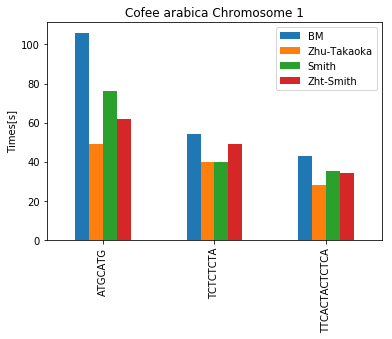

Mus Pahari Chromosome X


,BM,Zhu-Takaoka,Smith,Zht-Smith
ATGATG,229,157,159,187
CTCTCTA,158,129,120,156
TCACTACTCTCA,121,84,93,102


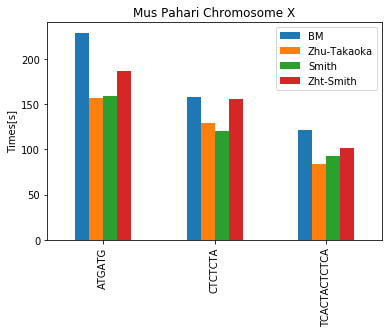

Vicugna pacos Chromosome 2


,BM,Zhu-Takaoka,Smith,Zht-Smith
TTTGTTTTCAGCTGAAGGATATACTTAAGGTGATGCTTTTGGCCTTTTCAGGGAGGGAGTCAGGGTTCCA,84,28,101,36
CTGAAGTGTTCCATGTGTTACTTTAGCTTGGT,95,49,95,62
AATAGAA,140,125,124,145


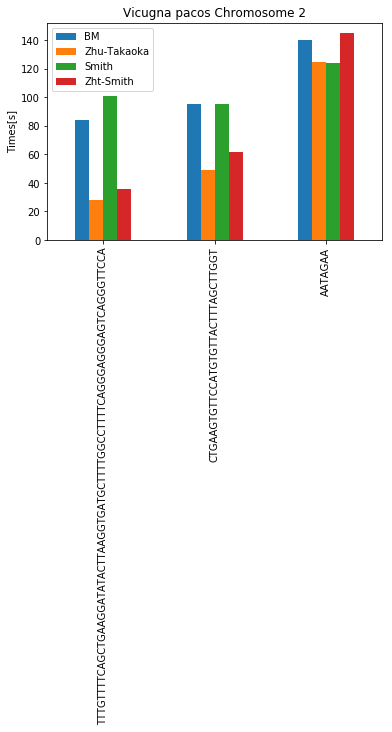

In [14]:
#data visualization: time performances

for test in tests :
    df = pd.DataFrame(test['times'], columns=test['heur_print'], index=test['patterns'])
    print(test['name_print'])
    display(df)
    
    df.plot(kind='bar', title=test['name_print'])
    plt.ylabel('Times[s]')
    plt.show()

Cofee arabica Chromosome 1


,BM,Zhu-Takaoka,Smith,Zht-Smith
ATGCATG,2440,2400,1504,2976
TCTCTCTA,2536,2288,1408,2768
TTCACTACTCTCA,3464,2560,1440,3072


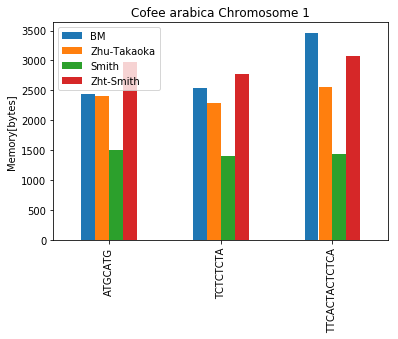

Mus Pahari Chromosome X


,BM,Zhu-Takaoka,Smith,Zht-Smith
ATGATG,2280,2352,1440,2864
CTCTCTA,2376,2272,1408,2752
TCACTACTCTCA,3336,2544,1440,3056


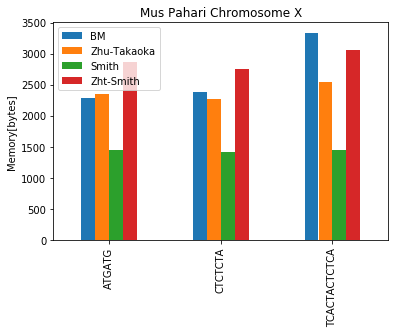

Vicugna pacos Chromosome 2


,BM,Zhu-Takaoka,Smith,Zht-Smith
TTTGTTTTCAGCTGAAGGATATACTTAAGGTGATGCTTTTGGCCTTTTCAGGGAGGGAGTCAGGGTTCCA,13000,3728,1504,4304
CTGAAGTGTTCCATGTGTTACTTTAGCTTGGT,6656,3152,1504,3728
AATAGAA,2480,2472,1440,2984


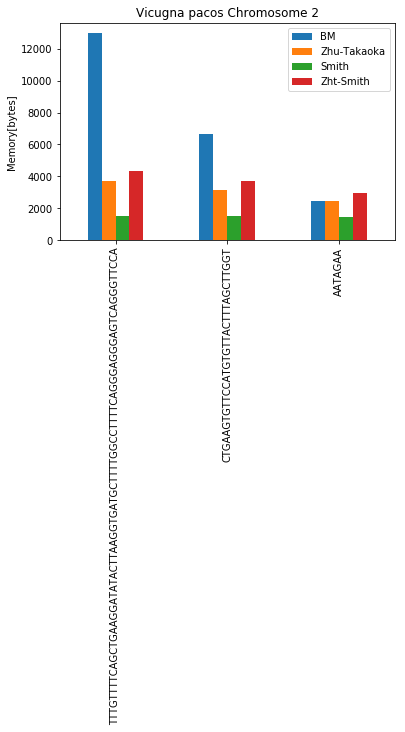

In [15]:
#data visualization: memory consumption
for test in tests :
    df = pd.DataFrame(test['memory'], columns=test['heur_print'], index=test['patterns'])
    print(test['name_print'])
    display(df)
    
    df.plot(kind='bar', title=test['name_print'])
    plt.ylabel('Memory[bytes]')
    plt.show()

In [ ]:
#Testing with wrapped BM functions

results = []
for test in tests : 
    for it in fasta_iter(test['file']) :
        print('Testing file: ' + test['name_print'])
        #text = it.seq
        text = 'AAAAAATTTTTTTTTTTTTTTTTTTTTTTTTCCCCCTTCTTTCTTATATTCGCTATGCATCGCAGTCGTCAGTCAGTCGTCGTCGTAGTCGTCAGTCAGTCAGTCAGTCGTAGTCAGTCAGTCGTCAGTCAGT'
        text_len = len(text)
        
        test['times'] = []
        for pattern in test['patterns'] :
            print('\tPattern: ' + pattern)
            
            times = []
            for heuristics in test['heuristics'] : 
                print('\t\tHeuristic: ' + str(heuristics))
                
                before = datetime.now()
                bm_object = BoyerMoore(pattern,alphabet, *heuristics )
                construction_time = datetime.now() - before
                print('\t\t\tConstruction_time: ' + str(construction_time))
                
                before = datetime.now()
                result = boyer_moore(bm_object,text)
                search_time = datetime.now() - before 
                print('\t\t\tSearch time: ' + str(search_time) )
                
                times.append(search_time.seconds)
        
            #before = datetime.now()
            #naive_cnt = naive_fast(text, pattern)
            #naive_search_time = datetime.now() - before 
            #print('\t\tNaive search time: ' + str(naive_search_time) + ' Count: ' + str(len(naive_cnt)) )
            
            #times.append(naive_search_time.seconds)
            test['times'].append(times[:])
        
        #test['heur_print'].append('Naive')   
